## PART 1 - Identify Frost Risk Based on Average Cold Days

### Part 1A: Pull station geographical data

In [1]:
import pandas as pd

stn_ids = pd.read_fwf(
    'http://noaa-ghcn-pds.s3.amazonaws.com/ghcnd-stations.txt',
    header=None,
    infer_nrows=1000)
stn_ids.columns = ['ID', 'LAT', 'LON', 'ELEV', 'UKN', 'NAME', 'GSN', 'WBAN']
# stn_ids

### Part 1B: Use selected station to create a URL to pull data values

In [2]:
import pandas as pd

# --- Parameters ---
selected_station_id = 'USC00087205'
start_year = 1991
end_year = 2021

# --- Load station data from NOAA GHCN ---
url = f"s3://noaa-ghcn-pds/csv/by_station/{selected_station_id}.csv"

df = pd.read_csv(
    url,
    storage_options={"anon": True},
    dtype={'Q_FLAG': 'object', 'M_FLAG': 'object'},
    parse_dates=['DATE']
).set_index('DATE')

# Ensure datetime index and sort
df.index = pd.to_datetime(df.index)
df.sort_index(inplace=True)

# --- Filter to desired year range ---
df_range = df.loc[f'{start_year}-01-01':f'{end_year}-12-31']

# --- Keep only months October through January ---
df_oct_jan = df_range[df_range.index.month.isin([10, 11, 12, 1])]

# --- Preview ---
print(df_range.head())
print(df_oct_jan.head())

                     ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME
DATE                                                                      
1991-01-01  USC00087205    SNOW           0      P    NaN      0       NaN
1991-01-01  USC00087205    TOBS         217    NaN    NaN      0    1800.0
1991-01-01  USC00087205    TMAX         283    NaN    NaN      0    1800.0
1991-01-01  USC00087205    PRCP           0    NaN    NaN      0    1800.0
1991-01-01  USC00087205    SNWD           0    NaN    NaN      0       NaN
                     ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME
DATE                                                                      
1991-01-01  USC00087205    SNOW           0      P    NaN      0       NaN
1991-01-01  USC00087205    TOBS         217    NaN    NaN      0    1800.0
1991-01-01  USC00087205    TMAX         283    NaN    NaN      0    1800.0
1991-01-01  USC00087205    PRCP           0    NaN    NaN      0    1800.0
1991-01-01  USC00087205  

C:\Users\jared\AppData\Local\Temp\ipykernel_2288\1336622536.py:11: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


### Part 1C: Identify the frost risk (days at or below 32 and 28 respectively)

In [3]:
# --- Temperature conversion and threshold flags ---

# Keep only TMIN records from the filtered Oct–Jan 1991–2021 DataFrame
df_tmin = df_oct_jan[df_oct_jan['ELEMENT'] == 'TMIN'].copy()

# Convert tenths of °C to °F (NOAA GHCN convention)
df_tmin['VALUE_F'] = df_tmin['DATA_VALUE'] / 10 * 9/5 + 32

# Flag days below thresholds
df_tmin['below_32F'] = (df_tmin['VALUE_F'] <= 32).astype(int)
df_tmin['below_28F'] = (df_tmin['VALUE_F'] <= 28).astype(int)

print(df_tmin.head())

                     ID ELEMENT  DATA_VALUE M_FLAG Q_FLAG S_FLAG  OBS_TIME  \
DATE                                                                         
1991-01-01  USC00087205    TMIN         167    NaN    NaN      0    1800.0   
1991-01-02  USC00087205    TMIN         183    NaN    NaN      0    1800.0   
1991-01-03  USC00087205    TMIN         178    NaN    NaN      0    1800.0   
1991-01-04  USC00087205    TMIN         178    NaN    NaN      0    1800.0   
1991-01-05  USC00087205    TMIN         172    NaN    NaN      0    1800.0   

            VALUE_F  below_32F  below_28F  
DATE                                       
1991-01-01    62.06          0          0  
1991-01-02    64.94          0          0  
1991-01-03    64.04          0          0  
1991-01-04    64.04          0          0  
1991-01-05    62.96          0          0  


### Part 1D: Plot the results by month

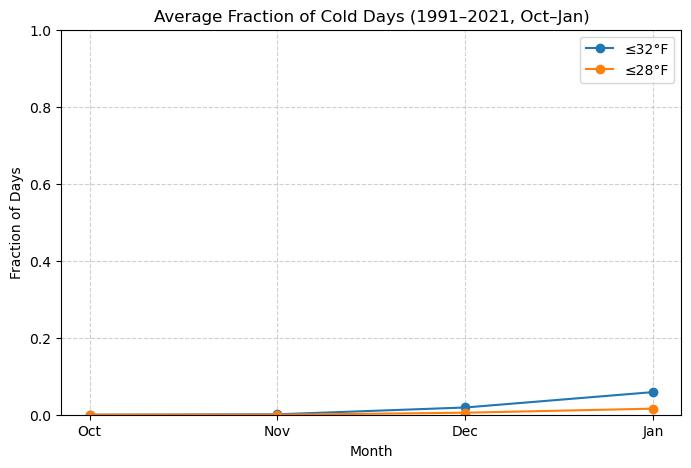

Average fraction of cold days per month (1991–2021, Oct–Jan):
     below_32F  below_28F
Oct      0.000      0.000
Nov      0.001      0.000
Dec      0.019      0.005
Jan      0.059      0.016


In [4]:
import calendar
import matplotlib.pyplot as plt

# --- Group by year-month and compute monthly fractions ---
monthly_counts = df_tmin.groupby([df_tmin.index.year, df_tmin.index.month])[
    ['below_32F', 'below_28F']
].mean()

# Convert MultiIndex (year, month) → DatetimeIndex for convenience
monthly_counts.index = pd.to_datetime(
    [f"{year}-{month:02d}-01" for year, month in monthly_counts.index]
)

# --- Average across all years for each month ---
avg_by_month = monthly_counts.groupby(monthly_counts.index.month).mean()

# Map numeric months to names
avg_by_month.index = [calendar.month_abbr[m] for m in avg_by_month.index]

# --- Restrict to Oct–Jan only ---
avg_oct_jan = avg_by_month.loc[['Oct', 'Nov', 'Dec', 'Jan']]

# --- Plot ---
plt.figure(figsize=(8,5))
plt.plot(avg_oct_jan.index, avg_oct_jan['below_32F'], marker='o', label='≤32°F')
plt.plot(avg_oct_jan.index, avg_oct_jan['below_28F'], marker='o', label='≤28°F')

plt.title('Average Fraction of Cold Days (1991–2021, Oct–Jan)')
plt.ylabel('Fraction of Days')
plt.xlabel('Month')
plt.ylim(0,1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

# --- Create numeric summary table ---

# Build a DataFrame with the averages
summary_table = avg_oct_jan.copy()

# Round for readability
summary_table = summary_table.round(3)

print("Average fraction of cold days per month (1991–2021, Oct–Jan):")
print(summary_table)


## PART 2 - Identify Identify ENSO Index Most Correlated with Frost Days

### Part 2A - Load Regional SST Anomaly Data Into a Dataframe

In [5]:
import pandas as pd

# --- Load ENSO dataset directly from NOAA CPC ---
enso_url = "https://www.cpc.ncep.noaa.gov/data/indices/sstoi.indices"
df_enso = pd.read_csv(enso_url, delim_whitespace=True)

# --- Ensure DATE column exists ---
df_enso['DATE'] = pd.to_datetime(
    df_enso['YR'].astype(str) + '-' + df_enso['MON'].astype(str).str.zfill(2)
)
df_enso = df_enso.set_index('DATE')

# --- Filter to 1991–2020 ---
df_enso_1991_2020 = df_enso.loc['1991-01-01':'2020-12-31']

# --- Keep only months October through January ---
df_enso_oct_jan = df_enso_1991_2020[df_enso_1991_2020.index.month.isin([10, 11, 12, 1])]

print(df_enso_oct_jan.head())
print(df_enso_oct_jan.tail())

C:\Users\jared\AppData\Local\Temp\ipykernel_2288\674621613.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_enso = pd.read_csv(enso_url, delim_whitespace=True)


              YR  MON  NINO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM.2  NINO3.4  \
DATE                                                                          
1991-01-01  1991    1    23.73 -0.78  25.63   -0.05  28.62    0.40    26.89   
1991-10-01  1991   10    21.09  0.22  25.36    0.27  29.31    0.63    27.41   
1991-11-01  1991   11    21.92  0.29  25.93    0.73  29.12    0.44    27.71   
1991-12-01  1991   12    23.13  0.29  26.30    1.03  29.21    0.77    28.14   
1992-01-01  1992    1    24.59  0.07  26.86    1.18  28.80    0.58    28.23   

            ANOM.3  
DATE                
1991-01-01    0.33  
1991-10-01    0.64  
1991-11-01    0.89  
1991-12-01    1.50  
1992-01-01    1.67  
              YR  MON  NINO1+2  ANOM  NINO3  ANOM.1  NINO4  ANOM.2  NINO3.4  \
DATE                                                                          
2019-12-01  2019   12    23.11  0.27  25.56    0.29  29.29    0.85    27.08   
2020-01-01  2020    1    24.49 -0.03  25.89    0.22  29.16    

### Create a Dataframe of Plant City Days Below 28 by Month by Year

In [6]:
# Build a year × month table of counts of days ≤28°F (Oct–Jan) for 1991–2020, avoiding DATE conflicts. Had to work with CoPilot to fix this

# Safety: drop any stray DATE column to avoid "cannot insert DATE" errors downstream
df_tmin = df_tmin.drop(columns=['DATE'], errors='ignore')

# Ensure we’re in the 1991–2020 window and Oct–Jan months
df_tmin = df_tmin[(df_tmin.index.year >= 1991) & (df_tmin.index.year <= 2020)]
df_tmin = df_tmin[df_tmin.index.month.isin([10, 11, 12, 1])]

# Group by Year and Month, sum the ≤28°F flags (counts of days)
counts_28 = (
    df_tmin['below_28F']
    .groupby([df_tmin.index.year.rename('Year'),
              df_tmin.index.month.rename('Month')])
    .sum()
)

# Pivot to Year rows × Month columns WITHOUT reset_index (avoids DATE insertion issues)
pivot_table = counts_28.unstack('Month')

# Rename month numbers to names and order seasonally
month_map = {1: 'Jan', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
pivot_table = pivot_table.rename(columns=month_map)

# Keep only Oct–Jan columns in desired order; fill missing with 0 and cast to int
pivot_table = pivot_table.reindex(columns=['Oct', 'Nov', 'Dec', 'Jan']).fillna(0).astype(int)

# Optional: add a total for Oct–Jan per year
pivot_table['Total_OctJan'] = pivot_table[['Oct', 'Nov', 'Dec', 'Jan']].sum(axis=1)

print(pivot_table.head(10))

Month  Oct  Nov  Dec  Jan  Total_OctJan
Year                                   
1991     0    0    0    0             0
1992     0    0    0    0             0
1993     0    0    0    0             0
1994     0    0    0    0             0
1995     0    0    3    0             3
1996     0    0    0    0             0
1997     0    0    0    1             1
1998     0    0    0    0             0
1999     0    0    0    3             3
2000     0    0    0    0             0


### Merge Cold Day Data and Regional Anomaly Data

In [7]:
import pandas as pd

# --- ENSO anomalies (Oct–Jan, 1991–2020) ---
df_enso['DATE'] = pd.to_datetime(
    df_enso['YR'].astype(str) + '-' + df_enso['MON'].astype(str).str.zfill(2)
)
df_enso = df_enso.set_index('DATE')

df_enso_1991_2020 = df_enso.loc['1991-01-01':'2020-12-31']
df_enso_oct_jan = df_enso_1991_2020[df_enso_1991_2020.index.month.isin([10, 11, 12, 1])]

# Keep Year, Month, and anomaly columns, then rename
enso_anom = df_enso_oct_jan[['ANOM', 'ANOM.1', 'ANOM.2', 'ANOM.3']].copy()
enso_anom = enso_anom.rename(columns={
    'ANOM': 'NINO1+2_ANOM',
    'ANOM.1': 'NINO3_ANOM',
    'ANOM.2': 'NINO4_ANOM',
    'ANOM.3': 'NINO_3_4_ANOM'
})
enso_anom['Year'] = enso_anom.index.year
enso_anom['Month'] = enso_anom.index.month

# --- Cold-day counts (pivot_table already built earlier) ---
cold_days_long = pivot_table[['Oct','Nov','Dec','Jan']].reset_index().melt(
    id_vars='Year', var_name='MonthName', value_name='Days_below_28F'
)

month_map = {'Oct':10, 'Nov':11, 'Dec':12, 'Jan':1}
cold_days_long['Month'] = cold_days_long['MonthName'].map(month_map)

# --- Merge ENSO anomalies with cold-day counts ---
merged = pd.merge(
    cold_days_long,
    enso_anom,
    on=['Year','Month'],
    how='inner'
)

# --- Compute Pearson correlations ---
corr = merged[['Days_below_28F','NINO1+2_ANOM','NINO3_ANOM','NINO4_ANOM','NINO_3_4_ANOM']].corr(method='pearson')

print("Merged dataset head:")
print(merged.head())

print("\nPearson correlations between cold-day counts and ENSO anomalies:")
print(corr)

Merged dataset head:
   Year MonthName  Days_below_28F  Month  NINO1+2_ANOM  NINO3_ANOM  \
0  1991       Oct               0     10          0.22        0.27   
1  1992       Oct               0     10          0.12       -0.42   
2  1993       Oct               0     10          0.32        0.20   
3  1994       Oct               0     10          0.69        0.49   
4  1995       Oct               0     10         -0.82       -0.90   

   NINO4_ANOM  NINO_3_4_ANOM  
0        0.63           0.64  
1       -0.24          -0.50  
2       -0.02           0.19  
3        0.50           0.60  
4       -0.57          -0.94  

Pearson correlations between cold-day counts and ENSO anomalies:
                Days_below_28F  NINO1+2_ANOM  NINO3_ANOM  NINO4_ANOM  \
Days_below_28F        1.000000     -0.135629   -0.122463   -0.135148   
NINO1+2_ANOM         -0.135629      1.000000    0.870064    0.549747   
NINO3_ANOM           -0.122463      0.870064    1.000000    0.805135   
NINO4_ANOM        

### Show Correlations From Highest to Lowest

In [8]:
import pandas as pd

# Assume `corr` is the correlation matrix from the previous step
# Extract correlations of cold-day counts with each ENSO region
corr_series = corr.loc['Days_below_28F', ['NINO1+2_ANOM','NINO3_ANOM','NINO4_ANOM','NINO_3_4_ANOM']]

# Build a tidy DataFrame
corr_table = pd.DataFrame({
    'ENSO Region': corr_series.index,
    "Pearson's Correlation Coefficient": corr_series.values
})

# Order from highest to lowest correlation
corr_table = corr_table.sort_values(by="Pearson's Correlation Coefficient", ascending=False).reset_index(drop=True)

print(corr_table)

     ENSO Region  Pearson's Correlation Coefficient
0  NINO_3_4_ANOM                          -0.112039
1     NINO3_ANOM                          -0.122463
2     NINO4_ANOM                          -0.135148
3   NINO1+2_ANOM                          -0.135629


### Plot Results Showing Counts and Correlation (Sanity Check)

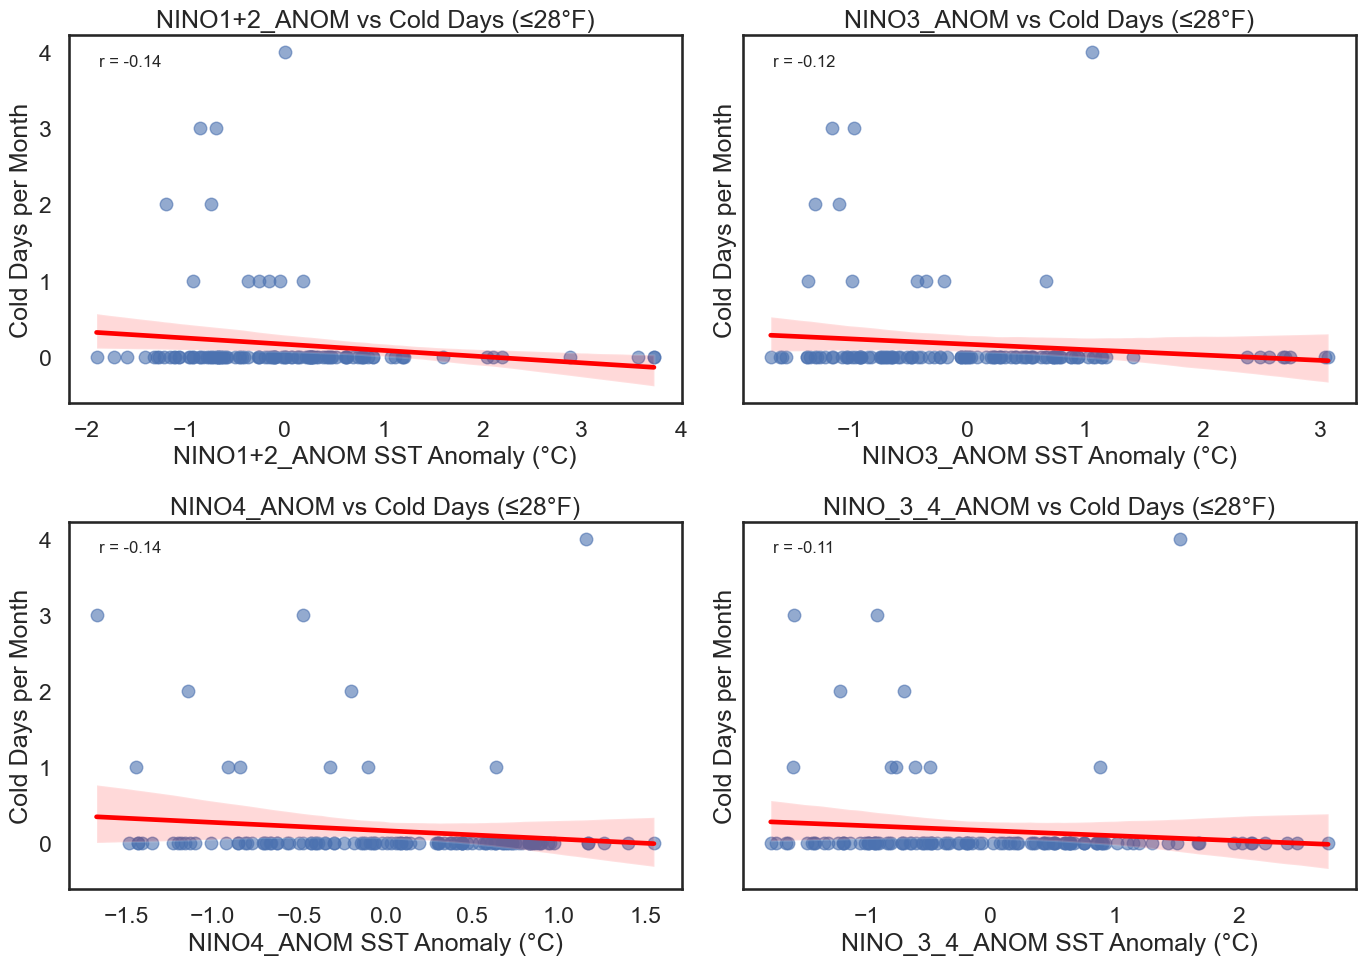

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Assume merged dataset already exists ---
# merged contains: ['Year','Month','MonthName','Days_below_28F',
#                   'NINO1+2_ANOM','NINO3_ANOM','NINO4_ANOM','NINO_3_4_ANOM']

sns.set(style="white", context="talk")

enso_regions = ['NINO1+2_ANOM','NINO3_ANOM','NINO4_ANOM','NINO_3_4_ANOM']

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)
axes = axes.flatten()

for i, region in enumerate(enso_regions):
    ax = axes[i]
    # Scatter + regression line
    sns.regplot(
        data=merged,
        x=region,
        y='Days_below_28F',
        ax=ax,
        scatter_kws={'alpha':0.6},
        line_kws={'color':'red'}
    )
    ax.set_title(f"{region} vs Cold Days (≤28°F)")
    ax.set_xlabel(f"{region} SST Anomaly (°C)")
    ax.set_ylabel("Cold Days per Month")

    # Compute Pearson correlation
    r = merged[['Days_below_28F', region]].corr(method='pearson').iloc[0,1]
    ax.text(0.05, 0.95, f"r = {r:.2f}", transform=ax.transAxes,
            fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()

## Conclusion

1) The number of days below 32 is low for each month in the time period ranging from none in October to just over a half a day in January (about every other year)

2) The days below 28 is even less. Ranging from zero to 0.16 days on average or about every 6 years on average.

3) The El Nino sea surface anomalies are slightly negatively correlated with severe freeze events (below 28).  The largest negative correlation is in the NINO1+2 region. That correlation is not very strong at -0.135629, but does exist.

4) Put another way, when we see negative temperature anomalies in that region, there is a slightly higher chance of seeing a severe freeze. Conversely when the anomaly is positive, the chances of a severe freeze are lower.

4) The spread among the regions is not very large. So negative SST anomalies in any region or the entire basin indicate a higher change for severe freezes. But if we had to look at only one region, the NINO1+2 region is the strongest predictor.